In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("Accent")

**Disclaimer:**
To analyze the architectures, we don't use Julia, but Python, because there is no need for performance optimized code and Python offers a simpler and more convenient way to work with data.

In [3]:
filenames = [
    filename
    for filename in os.listdir("../data/")
    if filename.endswith(".xlsx") and "Scenario_" in filename
]
generator_dfs = {
    filename: pd.read_excel(f"../data/{filename}", sheet_name="Gen")
    for filename in filenames
}
for architecture, generator_df in generator_dfs.items():
    generator_df["Architecture"] = architecture.split("_")[1].split(".")[0]
generator_df = pd.concat(generator_dfs).reset_index(drop=True)
generator_df.head()

,Generator Number,On Bus No.,Pmax [MW],Pmin [MW],Qmax [MVAr],Qmin [MVAr],Type,Costs [€/MW],CO2-Coefficient [t CO2/MWh_electric],Architecture
0,1,115,400.0,168,200.0,-200.0,Gas,121.56,0.74,2023B
1,2,12,600.0,297,300.0,-300.0,CCGT,80.25,0.49,2023B
2,3,38,1500.0,623,750.0,-750.0,Hard Coal,47.42,0.80,2023B
3,4,35,1600.0,843,800.0,-800.0,Lignite,36.05,1.10,2023B
4,5,19,800.0,389,400.0,-400.0,CCGT,76.86,0.47,2023B


In [4]:
mix_per_architecture = (
    generator_df.groupby(["Architecture", "Type"])["Pmax [MW]"]
    .sum()
    .unstack()
    .fillna(0)
)
mix_per_architecture


Type,CCGT,Gas,Hard Coal,Lignite,Nuclear,Solar,Wind
Architecture,,,,,,,
2013,7700.0,2000.0,10400.0,7700.0,3800.0,9361.0,10766.3
2023A,7700.0,1200.0,11800.0,6400.0,0.0,20216.0,20479.2
2023B,10010.0,2000.0,9500.0,6400.0,0.0,22263.0,23027.6
2023C,9610.0,2000.0,8800.0,6400.0,0.0,19269.0,35974.3


In [5]:
# mw to gw
mix_per_architecture = mix_per_architecture / 1000

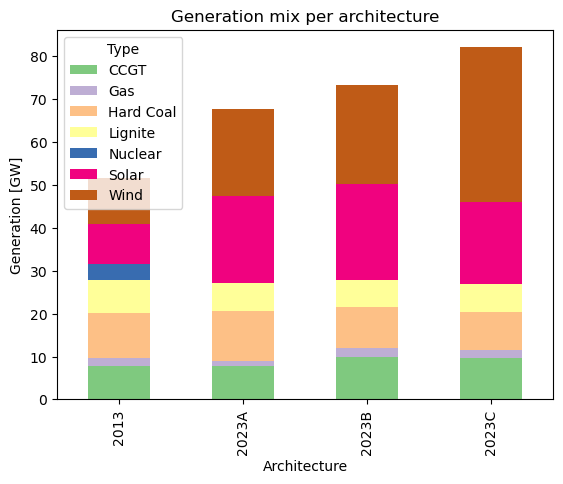

In [16]:
ax = mix_per_architecture.plot(kind="bar", stacked=True)
ax.set_title("Generation mix per architecture")
ax.set_ylabel("Generation [GW]")

plt.savefig("../figures/generation_mix_per_architecture.png", bbox_inches="tight")
plt.show()

In [7]:
mix_tmp = mix_per_architecture.copy()
renewable_types = ["Wind", "Solar"]
fossil_types = ["CCGT", "Gas", "Hard Coal", "Lignite", "Nuclear"]
mix_tmp["renewables"] = mix_tmp[renewable_types].sum(axis=1)
mix_tmp["fossil"] = mix_tmp[fossil_types].sum(axis=1)

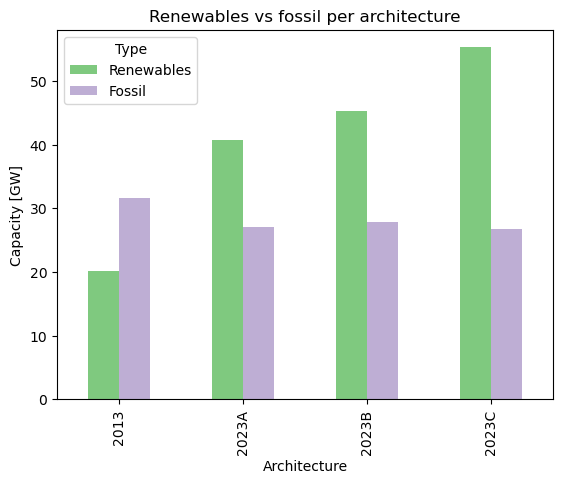

In [15]:
ax = mix_tmp[["renewables", "fossil"]].rename(columns={
	"renewables": "Renewables",
	"fossil": "Fossil"
}).plot(kind="bar")
ax.set_title("Renewables vs fossil per architecture")
ax.set_ylabel("Capacity [GW]")
plt.savefig("../figures/renewables_vs_fossil_per_architecture.png", bbox_inches="tight")
plt.show()

# Demand

In [9]:
demand = pd.read_excel("../data/Scenario_2013.xlsx", sheet_name="hourly_BusLoadP (MW)")
demand = demand.rename(columns={"Hour/Bus No.": "hour"})
demand["datetime"] = pd.date_range(
    start="2013-01-01 00:00:00",
    end="2013-12-31 23:00:00",
    freq="H",
)
demand = demand.drop(columns=["hour"]).set_index("datetime")

In [10]:
demand_total = demand.sum(axis=1)
demand_total = demand_total.to_frame("demand")
demand_total["month"] = demand_total.index.month
demand_total

,demand,month
datetime,,
2013-01-01 00:00:00,12706.10,1
2013-01-01 01:00:00,12058.64,1
2013-01-01 02:00:00,11394.05,1
2013-01-01 03:00:00,11088.60,1
2013-01-01 04:00:00,10744.10,1
...,...,...
2013-12-31 19:00:00,15270.47,12
2013-12-31 20:00:00,15071.74,12
2013-12-31 21:00:00,14810.17,12


In [11]:
demand_per_month = demand_total.groupby("month").sum()
demand_per_month

,demand
month,
1,15015375.48
2,14400028.30
3,14987990.50
4,13084596.59
5,12829885.01
6,12689771.87
7,12389632.08
8,13019975.24
9,12919802.97


In [12]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

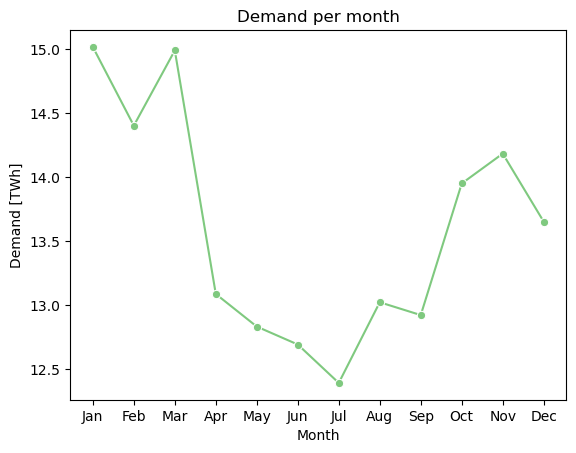

In [13]:
fig, ax = plt.subplots()
sns.lineplot(
    data=demand_per_month/1000/1000,
    x=demand_per_month.index.map(lambda x: months[x - 1]),
    y="demand",
    ax=ax,
    marker="o",
)
ax.set_title("Demand per month")
ax.set_xlabel("Month")
ax.set_ylabel("Demand [TWh]")
plt.show()
